In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from prox import prox
from alg.eig import power_iter
from alg.cg import CG
from linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2d, Gmri
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn

## FFT example
First example shows the basic usage of linear operators.
You can use +, -, * like matrices, as long as the size matches.
.H calls the adjoint operatos.

In [ ]:
# Assign device
device0 = torch.device('cuda:0')
# Load image
from skimage.data import shepp_logan_phantom
I_shepp = torch.tensor(shepp_logan_phantom()).to(device0)
# Define operator
Fop = FFTCn((400, 400), (400, 400), (0,1), norm = 'ortho')
k_shepp = Fop*I_shepp

show the k-space

In [ ]:
plt.imshow(torch.log(torch.abs(k_shepp)).cpu().data.numpy())
plt.colorbar()

## MRI parallel imaging example (SENSE)
Here we trys a 8-times equidistant 1d undersampling mask.
Both conjugate phase reconstruction (A'y)
and quadratic roughness least-squares reconstruction (argmin(x) \|Ax-y\|_2^2 + \lambda \|Rx\|_2^2) are shown.

In [ ]:
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = Fop.H*k_c
I1 = torch.sqrt(I1.abs().pow(2).sum(dim=0))
# Define undersampling mask
mask = torch.zeros(nh,nw)
mask[:,0:nw:8]=1
# Define sense operator
Sop = Sense(s_c, mask, batchmode = False)
# Zero-filled reconstruction
I0 = Sop.H*k_c
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I0).data.numpy())
plt.colorbar()
plt.title('zero-filled')

Define the quadratic roughness penalty, and corresponding CG reconstruction.

In [ ]:
T = Diff2d(Sop.size_in, dims = (0,1))
CG_tik = CG(Sop.H*Sop+0.01*T.H*T, max_iter = 40)

In [ ]:
# I0 is both the initialization, and the b in Ax = b.
I_tik = CG_tik.run(I0, I0)
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_tik).cpu().data.numpy())
plt.colorbar()
plt.title('Recovered')

## Non-Cartesian reconstruction
Here we test a non-Cartesian reconstruction cases.

In [2]:
hf = h5py.File('./b0.h5', 'r')
nx = 320;
ny = 320;
# Load Non-cartesian k-space trajectory
ktraj = hf['ktraj'][()]
ktraj = np.remainder(ktraj + np.pi, 2*np.pi)-np.pi
print('traj shape', ktraj.shape)
# Load k-space
k = hf['k_r'][()] + 1j*hf['k_i'][()]
[ncoil, nslice, nshot, ns] = k.shape
print('k shape', k.shape)
# Load density compensation function
dcf = hf['dcf'][()]
print('dcf shape', dcf.shape)
# Load sensetivity maps
smap = np.transpose(hf['s_r'][()] + 1j*hf['s_i'][()], (3,0,1,2))
smap = np.transpose(smap, (0,1,3,2))
[_, _, nx, ny] = smap.shape
print('smap shape', smap.shape)
# Load fmaps
fmap = hf['b0'][()]
fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)
# Define undersampling mask
ktrajunder = ktraj.reshape(2,320,1280)
ktrajunder = ktrajunder[:,0:-1:5,:].reshape(2,81920)
kunder = k[:,:,0:-1:5,:]

traj shape (2, 409600)
k shape (32, 15, 320, 1280)
dcf shape (1, 409600)
smap shape (15, 32, 320, 320)
fmap shape (15, 320, 320)


In [3]:
im_size = (nx,ny)
iz = 6
device0 = torch.device('cuda:0')
k0 = torch.tensor(kunder[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot*ns//5)
s0 = torch.tensor(smap[iz,:,:,:]).to(device = device0).unsqueeze(0)
traj0 = torch.tensor(ktrajunder).to(device = device0)
Nop = NuSense(s0, traj0)

In [5]:
I0 = Nop.H*k0
T = Diff2d(Nop.size_in, dims = (1,2))
CG_FD = CG(Nop.H*Nop+0.0001*T.H*T, max_iter = 40)
I_FD = CG_FD.run(I0, I0)

residual at 1th iter: 17383129344005.566
residual at 2th iter: 1002671813343.4443
residual at 3th iter: 99343675263.48615
residual at 4th iter: 12192039914.656202
residual at 5th iter: 1442336039.8587427
residual at 6th iter: 279043679.18576324
residual at 7th iter: 94328131.19486113
residual at 8th iter: 45741050.81677634
residual at 9th iter: 40063243.99814607
residual at 10th iter: 23785142.972556736
residual at 11th iter: 9870429.500531416
residual at 12th iter: 8611669.631709078
residual at 13th iter: 12551655.63790648
residual at 14th iter: 5881471.232424803
residual at 15th iter: 4770980.052892843
residual at 16th iter: 2617418.0854513007
residual at 17th iter: 1968964.427323706
residual at 18th iter: 1910345.2892871543
residual at 19th iter: 4222416.930177767
residual at 20th iter: 1236094.1503116237
residual at 21th iter: 926884.972446303
residual at 22th iter: 1297374.6977413807
residual at 23th iter: 1398184.553979859
residual at 24th iter: 736259.5446263369
residual at 25th

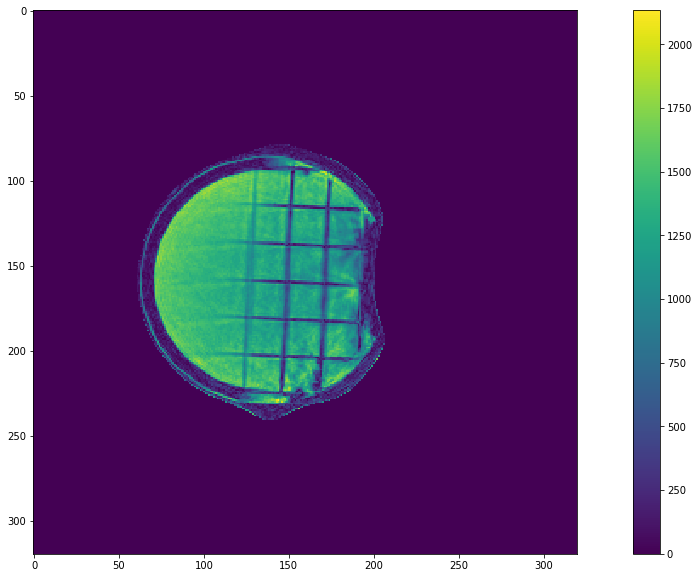

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_FD.squeeze(0).squeeze(0)).cpu().data.numpy())
plt.colorbar()

In [13]:
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj0.reshape(2,nshot//5, ns).unsqueeze(0))

C shape torch.Size([6, 1, 320, 320])
c shape (102400, 6)


In [14]:
Ib0 = Gop.H*k0.reshape(1,ncoil,nshot//5,ns)

In [15]:
T = Diff2d(Gop.size_in, dims = (1,2))
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T.H*T, max_iter = 40)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

residual at 1th iter: 17402006349877.45
residual at 2th iter: 1003938234884.9989
residual at 3th iter: 99665364125.80484
residual at 4th iter: 12250053977.739464
residual at 5th iter: 1448526140.6031544
residual at 6th iter: 279058529.9556985
residual at 7th iter: 93864323.06897868
residual at 8th iter: 45569660.66596196
residual at 9th iter: 40206003.450087816
residual at 10th iter: 23857439.125596713
residual at 11th iter: 9929927.626949724
residual at 12th iter: 8024624.922779925
residual at 13th iter: 14363527.027222589
residual at 14th iter: 5970374.292274476
residual at 15th iter: 4853454.838387037
residual at 16th iter: 2634990.724970103
residual at 17th iter: 2007962.7645435866
residual at 18th iter: 1893386.8666841625
residual at 19th iter: 4109391.2905522725
residual at 20th iter: 1259031.0264331
residual at 21th iter: 905371.439036597
residual at 22th iter: 836316.8886765392
residual at 23th iter: 2965766.264064276
residual at 24th iter: 704755.3729830309
residual at 25th it

Text(0.5, 1.0, 'Recovered')

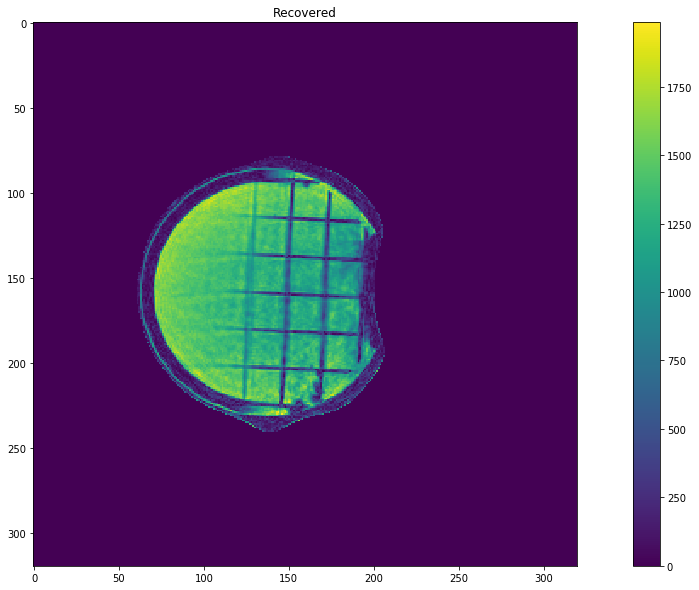

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_FD_b0[0]).cpu().data.numpy())
plt.colorbar()
plt.title('Recovered')